## Setup

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path    
from functools import reduce
import math
from matplotlib_venn import venn2, venn2_circles, venn3_circles, venn3
import os
import requests
import ast
import gseapy as gp
from gseapy import Msigdb
import json
import collections
import sys
sys.path.append("../../bin/")

from analysis_utils import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
analysis = "20240821_6rep_2MC_two_replicate_var_filter"

input_folder_path = Path("/Users/henrysanford/Downloads/02_wp_analysis/" + analysis)

wp_file_path_all_channels_ratio  = input_folder_path / "03_combined_files" / analysis / "03_combfiles_forpca_channelratio_or_rawsignal_wp.csv"
output_path = input_folder_path / "04_results"

PERFORM_GO_TERM_ANALYSIS = False

# remove proteins failing two replicate variability filter
wp_file_path_all_channels_ratio_df = pd.read_csv(
    wp_file_path_all_channels_ratio, index_col=[0]
)

dropout_uniprots = set(
    pd.read_csv(
        input_folder_path
        / "03_combined_files"
        / analysis
        / "09_combfiles_percctrl_fails_two_replicate_variability_filter.csv"
    )["uniprot"]
)

wp_file_path_all_channels_ratio_df = wp_file_path_all_channels_ratio_df[
    ~wp_file_path_all_channels_ratio_df["uniprot"].isin(dropout_uniprots)
]

## Principal component analysis

log2 scale signal intensities and drop proteins with missing data

In [8]:
pca_path = output_path / "pca"
Path(pca_path).mkdir(exist_ok=True, parents=True)
df = wp_file_path_all_channels_ratio_df.copy()
pepnum_list = df.filter(regex="pepNum").columns.tolist()
df = df.drop(["uniprot", "description"] + pepnum_list, axis=1)
pca_plot, loadings_df, pca_df, percent_df = get_pca_plot(df, "protein","Proteomics PCA", pca_path)

pca_plot.show()

In [9]:
# Filter to minimum four replicates

unwanted = wp_file_path_all_channels_ratio_df.columns[wp_file_path_all_channels_ratio_df.columns.str.startswith('pepNum')]
wp_file_path_all_channels_ratio_df.drop(unwanted, axis=1, inplace=True)
t_df = wp_file_path_all_channels_ratio_df.reset_index().drop(["protein", "description"], axis=1).set_index("uniprot").T.reset_index()
t_df["group"] = t_df["index"].str.split("_processed").str[0].str.rsplit("_").str[0]
t_df = t_df.drop("index", axis=1)
t_df = t_df.groupby("group").count()
t_df = t_df.T.max(axis=1) 
t_df = t_df[t_df >= 4] # min four replicates
uniprot_list = t_df.index.tolist()
wp_file_path_all_channels_ratio_df = wp_file_path_all_channels_ratio_df.reset_index()[wp_file_path_all_channels_ratio_df.reset_index()["uniprot"].isin(uniprot_list)]
wp_file_path_all_channels_ratio_df.drop("index", axis=1, inplace=True)

### GSEA of PC loadings

Takes about 7 minutes with 10000 permutations

In [10]:
def perform_gsea_proteomics(loading_results, gene_sets, output_dir, pc):
    """
    Perform GSEA on proteomics loading results.
    """
    # Sort proteins by loading score
    ranked_proteins = loading_results.sort_values(ascending=True, by=pc)

    # Perform GSEA
    gsea_results = gp.prerank(
        rnk=ranked_proteins,
        gene_sets=gene_sets,
        processes=4,
        correction="bh",
        permutation_num=10000,
        outdir=output_dir,
        seed=42,
        no_plot=True,
    )

    return gsea_results

""" msig = Msigdb()
# c5.go.bp = GO biological process
gmt_name = "c5.go.bp"
gmt = msig.get_gmt(gmt_name)


for pc in ["PC1", "PC2"]:
    pc_path = pca_path / pc
    pre_res = perform_gsea_proteomics(
        pd.DataFrame(loadings_df[pc]), gene_sets=gmt, output_dir=pc_path, pc=pc
    )

    df = pre_res.res2d
    df["abs_nes"] = -abs(df["NES"])
    df = df[df["NOM p-val"] < 0.01]

    terms = pre_res.res2d.Term[:10]  # Top 5 enriched terms
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    # Dot plot
    gp.plot.dotplot(
        pre_res.res2d,
        title=f"Top enriched terms for {pc}",
        cmap="viridis",
        size=5,
        top_term=15,
        ax=axes,
        column="FDR q-val",
    )
    plt.tight_layout()
    plt.savefig(
        pc_path / "top_enriched_terms.svg", bbox_inches="tight"
    )
    plt.show() """

' msig = Msigdb()\n# c5.go.bp = GO biological process\ngmt_name = "c5.go.bp"\ngmt = msig.get_gmt(gmt_name)\n\n\nfor pc in ["PC1", "PC2"]:\n    pc_path = pca_path / pc\n    pre_res = perform_gsea_proteomics(\n        pd.DataFrame(loadings_df[pc]), gene_sets=gmt, output_dir=pc_path, pc=pc\n    )\n\n    df = pre_res.res2d\n    df["abs_nes"] = -abs(df["NES"])\n    df = df[df["NOM p-val"] < 0.01]\n\n    terms = pre_res.res2d.Term[:10]  # Top 5 enriched terms\n    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))\n\n    # Dot plot\n    gp.plot.dotplot(\n        pre_res.res2d,\n        title=f"Top enriched terms for {pc}",\n        cmap="viridis",\n        size=5,\n        top_term=15,\n        ax=axes,\n        column="FDR q-val",\n    )\n    plt.tight_layout()\n    plt.savefig(\n        pc_path / "top_enriched_terms.svg", bbox_inches="tight"\n    )\n    plt.show() '

## Volcano plot

In [11]:
conditions_list = ["D4A", "D4C", "D8A", "D8C"]
volcano_path = output_path / "volcano_plots"
Path(volcano_path).mkdir(exist_ok=True)

In [12]:
index_cols = ["uniprot", "protein", "description"]
volcano_filename = volcano_path / "volcano_data.csv"
volcano_df, copy_df = get_volcano_plot_treatment_vs_control(
    conditions_list = conditions_list,
    control_labelling = "D2",
    df = wp_file_path_all_channels_ratio_df,
    file_name = "Exhaustion WP",
    folder_path = output_path,
    index_cols = index_cols,
    target_name = "Proteins"
)

In [13]:
def annotate_functional_categories(volcano_df):
    """Annotate the volcano_data plot with functional categories based 
    on curated gene lists
    """
    fun_groups = pd.read_csv("protein_lists/group_annotations_reduced.csv")
    for i, row in fun_groups.iterrows():
        proteins = set(pd.read_csv(row["file_name"])["uniprot"])
        volcano_df[row["column_name"]] = volcano_df.index.isin(proteins)
    return volcano_df

volcano_df = annotate_functional_categories(volcano_df.reset_index().set_index("uniprot"))

volcano_df.to_csv(volcano_filename)

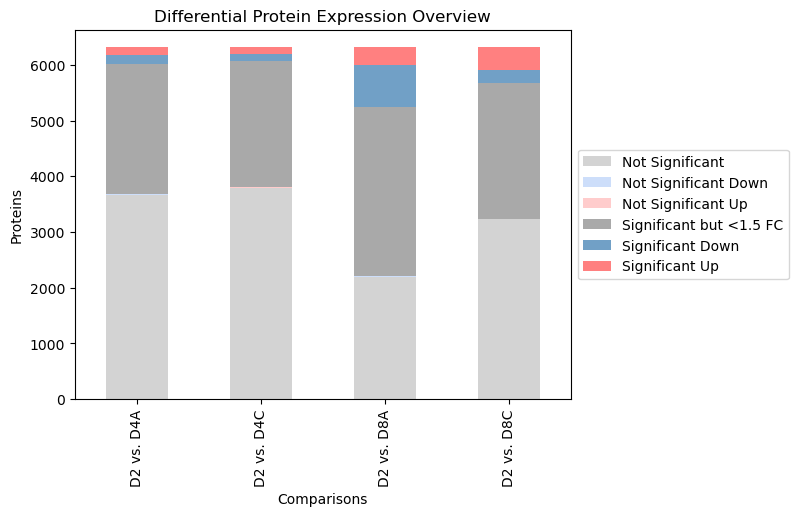

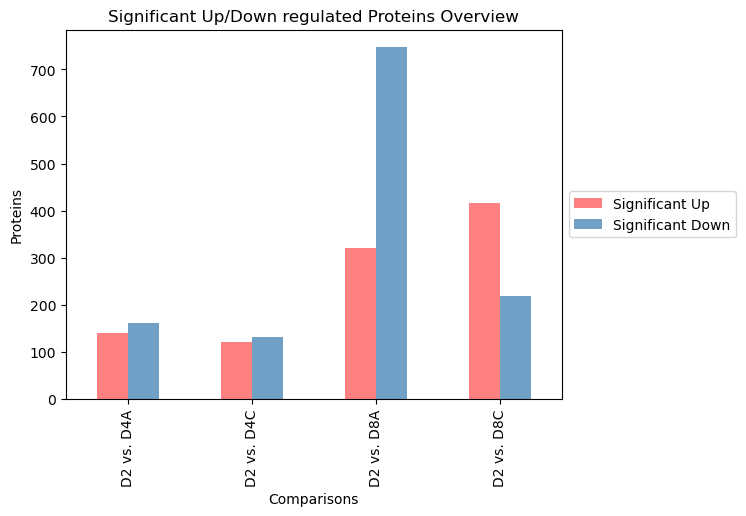

In [14]:
val_counts_list = []
reg_sub_df = volcano_df.filter(regex="Regulation_")
for col in reg_sub_df.columns:
    val_counts = reg_sub_df[col].value_counts().to_frame()
    val_counts.columns = [col]
    val_counts_list.append(val_counts)

val_count_df = pd.concat(val_counts_list, axis=1)
cols = []
for col in val_count_df.columns:
    col = col.split("Regulation_Exhaustion WP - ")[1].rsplit(" (")[0]
    cols.append(col)
val_count_df.columns = cols

new_index = [
    "Not Significant",
    "Not Significant Down",
    "Not Significant Up",
    "Significant but <1.5 FC",
    "Significant Down",
    "Significant Up",
]

val_count_df = val_count_df.T
val_count_df = val_count_df.reindex(new_index, axis=1)

val_count_df.plot(
    kind="bar",
    stacked=True,
    color=["lightgrey", "#CDDEFA", "#ffcccc", "darkgrey", "#71A0C6", "#ff8080"],
)
plt.xlabel("Comparisons")
plt.ylabel("Proteins")
plt.title("Differential Protein Expression Overview")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig(
    output_path / "volcano_plots" / "diff_expr_overview.svg", bbox_inches="tight"
)


val_count_df[["Significant Up", "Significant Down"]].plot(
    kind="bar", color=["#ff8080", "#71A0C6"]
)
plt.xlabel("Comparisons")
plt.ylabel("Proteins")
plt.title("Significant Up/Down regulated Proteins Overview")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig(
    output_path / "volcano_plots" / "signupdown_overview.svg", bbox_inches="tight"
)

In [15]:
d8a_conditions_list = ["D4A", "D4C", "D2", "D8C"]
volcano_path = output_path / "volcano_plots"
Path(volcano_path).mkdir(exist_ok=True)
d8a_volcano_filename = volcano_path / "volcano_data_compared_to_d8a.csv"
d8a_volcano_df, copy_df = get_volcano_plot_treatment_vs_control(
    d8a_conditions_list,
    "D8A",
    wp_file_path_all_channels_ratio_df,
    "Exhaustion WP",
    output_path,
    index_cols = index_cols,
    target_name = "Proteins"
)

d8a_volcano_df.to_csv(d8a_volcano_filename)

In [24]:
final_table = volcano_df.merge(
    right=d8a_volcano_df, left_index=True, right_index=True
)

final_table = annotate_functional_categories(final_table[
    final_table.columns[~final_table.columns.str.contains("index")]
].drop(["description","protein"], axis = 1).reset_index().set_index("uniprot"))

final_table = (
    wp_file_path_all_channels_ratio_df.set_index(
        ["uniprot", "protein", "description"]
    ).merge(final_table, left_index=True, right_index=True)
)
final_table.columns = [x.replace("D4A", "D4Q").replace("D8A", "D8Q") for x in final_table.columns]
final_table.to_excel(
    "Data S2.xlsx",
    startrow= 2,
    sheet_name="S2-2 Unenriched proteomics"
)

In [25]:
final_table

,,,D2_rep1_1_processed_census-out_041521_MOBN_20_WP_2024,D2_rep1_2_processed_census-out_041521_MOBN_20_WP_2024,D4Q_rep1_1_processed_census-out_041521_MOBN_20_WP_2024,D4Q_rep1_2_processed_census-out_041521_MOBN_20_WP_2024,D4C_rep1_1_processed_census-out_041521_MOBN_20_WP_2024,D4C_rep1_2_processed_census-out_041521_MOBN_20_WP_2024,D8Q_rep1_1_processed_census-out_041521_MOBN_20_WP_2024,D8Q_rep1_2_processed_census-out_041521_MOBN_20_WP_2024,D8C_rep1_1_processed_census-out_041521_MOBN_20_WP_2024,D8C_rep1_2_processed_census-out_041521_MOBN_20_WP_2024,...,p_value_Exhaustion WP - D8Q vs. D2 (6315 Proteins),log2_FC_Exhaustion WP - D8Q vs. D2 (6315 Proteins),-log10_pval_Exhaustion WP - D8Q vs. D2 (6315 Proteins),-log10_pval_adj_Exhaustion WP - D8Q vs. D2 (6315 Proteins),Regulation_Exhaustion WP - D8Q vs. D2 (6315 Proteins),p_value_Exhaustion WP - D8Q vs. D8C (6315 Proteins),log2_FC_Exhaustion WP - D8Q vs. D8C (6315 Proteins),-log10_pval_Exhaustion WP - D8Q vs. D8C (6315 Proteins),-log10_pval_adj_Exhaustion WP - D8Q vs. D8C (6315 Proteins),Regulation_Exhaustion WP - D8Q vs. D8C (6315 Proteins)
uniprot,protein,description,,,,,,,,,,,,,,,,,,,,,
P05387,RPLP2,Large ribosomal subunit protein P2 OS=Homo sapiens OX=9606 GN=RPLP2 PE=1 SV=1,0.117519,0.087130,0.110418,0.109171,0.108977,0.093861,0.090015,0.087770,0.102073,0.090460,...,3.520137e-06,0.440529,5.453440,4.709231,Significant but <1.5 FC,0.000031,0.363131,4.512732,3.868451,Significant but <1.5 FC
P12004,PCNA,Proliferating cell nuclear antigen OS=Homo sapiens OX=9606 GN=PCNA PE=1 SV=1,0.080598,0.058012,0.125158,0.114385,0.119456,0.105110,0.103663,0.100136,0.102366,0.089513,...,4.492547e-06,-0.486801,5.347507,4.623946,Significant but <1.5 FC,0.693101,0.032436,0.159203,0.132397,Not Significant
P09382,LGALS1,Galectin-1 OS=Homo sapiens OX=9606 GN=LGALS1 PE=1 SV=2,0.050791,0.035954,0.053409,0.055588,0.054207,0.045235,0.214985,0.211474,0.141988,0.120269,...,6.169889e-11,-1.936657,10.209723,8.338768,Significant Down,0.729502,-0.038769,0.136974,0.113301,Not Significant
O75368,SH3BGRL,Adapter SH3BGRL OS=Homo sapiens OX=9606 GN=SH3BGRL PE=1 SV=1,0.177683,0.133287,0.075091,0.079698,0.078771,0.070670,0.115908,0.110287,0.078607,0.074607,...,8.133205e-01,0.028385,0.089738,0.072622,Not Significant,0.010461,-0.255186,1.980437,1.731391,Significant but <1.5 FC
P05386,RPLP1,Large ribosomal subunit protein P1 OS=Homo sapiens OX=9606 GN=RPLP1 PE=1 SV=1,0.119407,0.086877,0.108266,0.108327,0.109274,0.096737,0.085502,0.085890,0.106030,0.091548,...,1.378658e-06,0.470401,5.860544,5.052282,Significant but <1.5 FC,0.000070,0.379573,4.153909,3.583985,Significant but <1.5 FC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9UM54,MYO6,Unconventional myosin-VI OS=Homo sapiens OX=9606 GN=MYO6 PE=1 SV=4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.186984e-03,0.554136,2.496620,2.170026,Significant but <1.5 FC,0.108579,0.282274,0.964256,0.832827,Not Significant
Q9Y2Y4,ZBTB32,Zinc finger and BTB domain-containing protein 32 OS=Homo sapiens OX=9606 GN=ZBTB32 PE=1 SV=1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.832131e-04,1.593113,3.737044,3.253688,Significant Up,0.001400,1.121881,2.853801,2.489431,Significant Up
L0R6Q1,SLC35A4,SLC35A4 upstream open reading frame protein OS=Homo sapiens OX=9606 GN=SLC35A4 PE=3 SV=1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.240972e-06,0.994115,5.906238,5.086323,Significant Up,0.014946,-0.270083,1.825489,1.594021,Significant but <1.5 FC


## Curating gene sets

In [27]:
if False:
    go_term_list_dir = Path(
        "/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/02_Mass-spectrometry data/Reference lists/GO_term_lists/"
    )

    query_gene_ontology(
        ["GO:0007049", "GO:0051301"], ["BP"], go_term_list_dir / "Cell cycle"
    )

    # nucleotide metabolism
    query_gene_ontology(
        ["GO:0055086", "GO:0008252"],
        ["BP", "MF"],
        go_term_list_dir / "Nucleotide metabolism",
    )

    # nucleotide binding
    query_gene_ontology(
        ["GO:0000166", "GO:0002135", "GO:0005525", "GO:0005524"],
        ["BP", "MF"],
        go_term_list_dir / "Nucleotide binding",
    )

    # Respiratory complex I-IV
    query_gene_ontology(
        ["GO:0005747", "GO:0005749", "GO:0005750", "GO:0005751"],
        ["CC"],
        go_term_list_dir / "Respiratory complex I-IV",
    )

    # Respiratory complex V
    query_gene_ontology(["GO:0045259"], ["CC"], go_term_list_dir / "Respiratory complex V")

## WP vs RNA Seq

In [30]:
wp_file_path_all_channels_ratio_df = wp_file_path_all_channels_ratio_df.set_index(["uniprot", "protein", "description"])

cond_list = ["D2", "D4A", "D4C", "D8A", "D8C"]
for cond_name in cond_list:
    filter_col = [col for col in wp_file_path_all_channels_ratio_df if col.startswith(cond_name)]
    wp_file_path_all_channels_ratio_df['median_'+cond_name] = wp_file_path_all_channels_ratio_df.loc[:, filter_col].median(axis = 1)
    wp_file_path_all_channels_ratio_df['mean_'+cond_name] = wp_file_path_all_channels_ratio_df.loc[:, filter_col].mean(axis = 1)
filter_col = [col for col in wp_file_path_all_channels_ratio_df if col.startswith("median_")]
median_conditions_df = wp_file_path_all_channels_ratio_df[filter_col]
filter_col = [col for col in wp_file_path_all_channels_ratio_df if col.startswith("mean_")]
mean_conditions_df = wp_file_path_all_channels_ratio_df[filter_col]
wp_file_path_all_channels_ratio_df = wp_file_path_all_channels_ratio_df.drop(filter_col, axis=1)
median_conditions_df.columns = median_conditions_df.columns.str.replace('median_', '')
mean_conditions_df.columns = mean_conditions_df.columns.str.replace('mean_', '')


In [31]:
# wp vs rnaseq
wp_rna_corr_folder = input_folder_path / "04_results" / "wp_vs_rnaseq"
Path(wp_rna_corr_folder).mkdir(exist_ok=True)
dgea_rnaseq_data_dir_path = Path(
    "/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/02_Mass-spectrometry data/00_rnaseqdata_from_Jahan/13524/results_deseq2"
)
merged_path = wp_rna_corr_folder / "wp_rna_merged"
Path(merged_path).mkdir(exist_ok=True)
dgea_csv_file_list_1 = list(Path(dgea_rnaseq_data_dir_path).glob("*.csv"))

rna_vs_wp_merged = []

for file_path in dgea_csv_file_list_1:
    df = pd.read_csv(file_path)
    df = df.rename(columns={"Unnamed: 0": "protein"})
    df = df.set_index("protein")
    df.columns = "RNA_" + df.columns
    df = df.reset_index()

    if "13524_pc_genes_D8-Ac_D2_results" in file_path.stem:
        subdf_list = [df, mean_conditions_df[["D2", "D8A"]].reset_index()]
        df_merged = reduce(
            lambda left, right: pd.merge(left, right, on=["protein"], how="inner"),
            subdf_list,
        )

    if "13524_pc_genes_D4-Chr_D2_results" in file_path.stem:
        subdf_list = [df, mean_conditions_df[["D2", "D4C"]].reset_index()]
        df_merged = reduce(
            lambda left, right: pd.merge(left, right, on=["protein"], how="inner"),
            subdf_list,
        )

    if "13524_pc_genes_D8-Chr_D2_results" in file_path.stem:
        subdf_list = [df, mean_conditions_df[["D2", "D8C"]].reset_index()]
        df_merged = reduce(
            lambda left, right: pd.merge(left, right, on=["protein"], how="inner"),
            subdf_list,
        )

    if "13524_pc_genes_D4-Ac_D2_results" in file_path.stem:
        subdf_list = [df, mean_conditions_df[["D2", "D4A"]].reset_index()]
        df_merged = reduce(
            lambda left, right: pd.merge(left, right, on=["protein"], how="inner"),
            subdf_list,
        )
    if "13524_pc_genes_D8-Chr_D8-Ac_results" in file_path.stem:
        subdf_list = [df, mean_conditions_df[["D8A", "D8C"]].reset_index()]
        df_merged = reduce(
            lambda left, right: pd.merge(left, right, on=["protein"], how="inner"),
            subdf_list,
        )
    print(df_merged.columns)
    df_merged.to_csv(merged_path / (file_path.stem + ".csv"))

Index(['protein', 'RNA_baseMean', 'RNA_log2FoldChange', 'RNA_lfcSE',
       'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot', 'description', 'D2',
       'D8C'],
      dtype='object')
Index(['protein', 'RNA_baseMean', 'RNA_log2FoldChange', 'RNA_lfcSE',
       'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot', 'description', 'D2',
       'D4A'],
      dtype='object')
Index(['protein', 'RNA_baseMean', 'RNA_log2FoldChange', 'RNA_lfcSE',
       'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot', 'description', 'D8A',
       'D8C'],
      dtype='object')
Index(['protein', 'RNA_baseMean', 'RNA_log2FoldChange', 'RNA_lfcSE',
       'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot', 'description', 'D2',
       'D8A'],
      dtype='object')
Index(['protein', 'RNA_baseMean', 'RNA_log2FoldChange', 'RNA_lfcSE',
       'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot', 'description', 'D2',
       'D4C'],
      dtype='object')


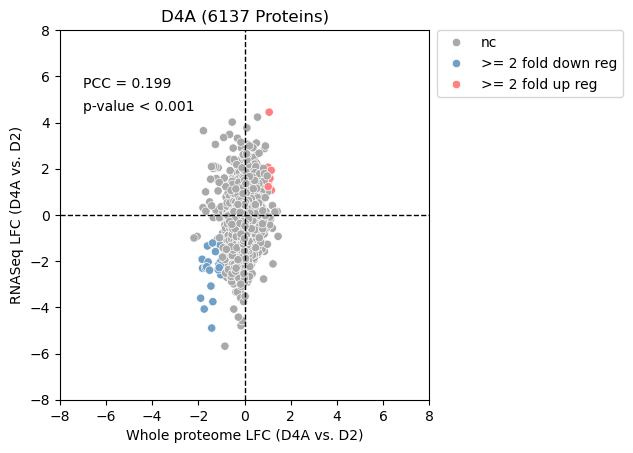

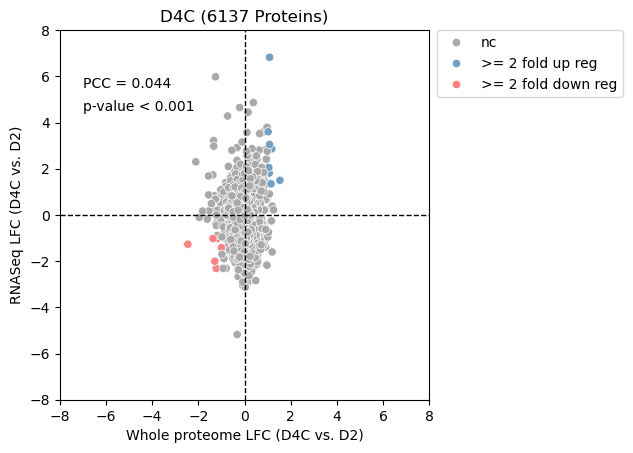

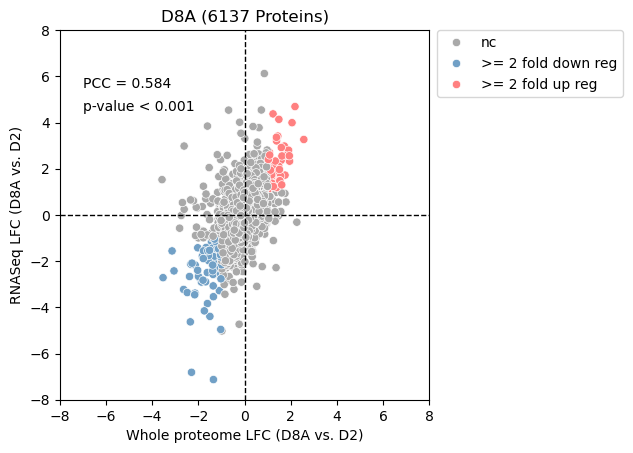

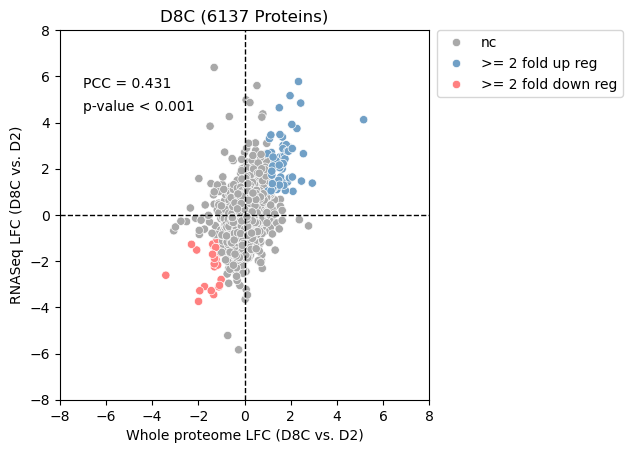

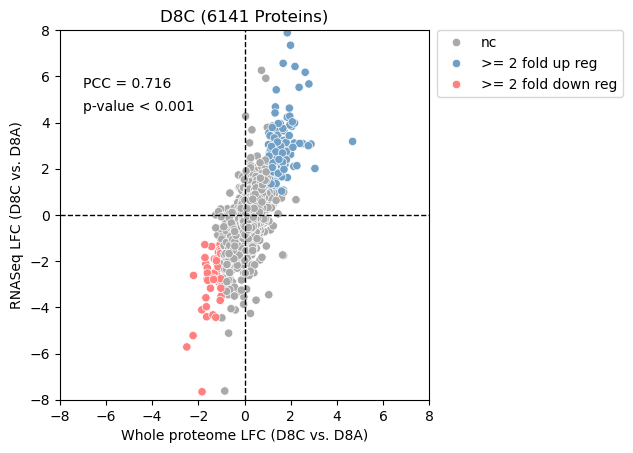

Index(['Unnamed: 0', 'protein', 'RNA_baseMean', 'RNA_log2FoldChange',
       'RNA_lfcSE', 'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot',
       'description', 'D2', 'D4A', 'FC', 'WP_log2FoldChange',
       'regulation_protein_rna'],
      dtype='object')
Index(['Unnamed: 0', 'protein', 'RNA_baseMean', 'RNA_log2FoldChange',
       'RNA_lfcSE', 'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot',
       'description', 'D2', 'D4C', 'FC', 'WP_log2FoldChange',
       'regulation_protein_rna'],
      dtype='object')
Index(['Unnamed: 0', 'protein', 'RNA_baseMean', 'RNA_log2FoldChange',
       'RNA_lfcSE', 'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot',
       'description', 'D2', 'D8A', 'FC', 'WP_log2FoldChange',
       'regulation_protein_rna'],
      dtype='object')
Index(['Unnamed: 0', 'protein', 'RNA_baseMean', 'RNA_log2FoldChange',
       'RNA_lfcSE', 'RNA_stat', 'RNA_pvalue', 'RNA_padj', 'uniprot',
       'description', 'D2', 'D8C', 'FC', 'WP_log2FoldChange',
       'regulation_protein_r

In [39]:
from scipy import stats
import seaborn as sb

def corr_plot_wp_rnaseq(file_path, condition, control, folder_path):
    # read in dataframe
    df = pd.read_csv(file_path)
    df = df.drop("Unnamed: 0", axis=1)
    df.drop(list(df.filter(regex="rep")), axis=1, inplace=True)
    df = df.dropna()
    plot_title = condition + " (" + str(df.shape[0]) + " Proteins)"

    # get fold change
    df["FC"] = df[condition] / df[control]
    # get log2 fold change
    df["WP_log2FoldChange"] = np.log2(df["FC"])

    # this will be the x and y axis labelling
    wp_string = "Whole proteome LFC (" + condition + " vs. " + control + ")"
    rnaseq_string = "RNASeq LFC (" + condition + " vs. " + control + ")"

    # add categorial column to identify values that are >=2 fold up or down regulated
    # we call the new column "fold_change"
    conditions = [
        (df["RNA_log2FoldChange"] <= -1) & (df["WP_log2FoldChange"] <= -1),
        (df["RNA_log2FoldChange"] >= 1) & (df["WP_log2FoldChange"] >= 1),
    ]

    choices = [">= 2 fold down reg", ">= 2 fold up reg"]
    df["fold_change"] = np.select(conditions, choices, default="nc")

    # add another categorial column to identify proteins which dont change in gene expression but in protein expression
    conditions = [
        (df["RNA_log2FoldChange"] <= 1)
        & (df["RNA_log2FoldChange"] >= -1)
        & (df["WP_log2FoldChange"] <= -1),
        (df["RNA_log2FoldChange"] <= 1)
        & (df["RNA_log2FoldChange"] >= -1)
        & (df["WP_log2FoldChange"] >= 1),
        (df["WP_log2FoldChange"] <= 1) & (df["WP_log2FoldChange"] >= -1) & (df["RNA_log2FoldChange"] <= -1),
        (df["WP_log2FoldChange"] <= 1) & (df["WP_log2FoldChange"] >= -1) & (df["RNA_log2FoldChange"] >= 1),
    ]

    choices = [
        "> protein expression down reg",
        "> protein expression up reg",
        "> gene expression down reg",
        "> gene expression up reg",
    ]
    df["expression"] = np.select(conditions, choices, default="nc")

    # save df
    df.to_csv(folder_path / (condition + " vs. " + control + ".csv"))

    r_pval = stats.pearsonr(df["WP_log2FoldChange"].tolist(), df["RNA_log2FoldChange"].tolist())
    if round(r_pval[1], 3) == 0.0:
        p_val = 0.001
    else:
        p_val = round(r_pval[1], 3)

    # print("PCC:", r_pval[0])
    # print("p-value:", r_pval[1])

    # remove inf values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna(subset=["WP_log2FoldChange", "RNA_log2FoldChange"])

    # Creation of scatterplot
    ax = sb.scatterplot(
        x="WP_log2FoldChange",
        y="RNA_log2FoldChange",
        hue="fold_change",
        data=df,
        palette=["darkgray", "#71A0C6", "#ff8080"],
    )
    ax.set_title(plot_title)
    ax.set_xlabel(wp_string)
    ax.set_ylabel(rnaseq_string)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    ax.axhline(0, linewidth=1, color="black", linestyle="--")
    ax.axvline(0, linewidth=1, color="black", linestyle="--")

    # labelling of data in scatterplot
    subset_df = df[df["fold_change"] != "nc"]
    subset_df = subset_df.reset_index()

    # for line in range(0,subset_df.shape[0]):
    #     plt.text(subset_df['WP_log2FoldChange'][line], subset_df['RNA_log2FoldChange'][line], subset_df.protein[line], horizontalalignment='left', size='small', color='black', weight='ultralight')

    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

    ax.text(-7, 5.5, r"PCC = {}".format(round(r_pval[0], 3)))
    ax.text(-7, 4.5, r"p-value < {}".format(p_val))
    ax.set_box_aspect(1)

    plt.savefig(
        folder_path / ("corr_wp_rnaseq" + condition + " vs. " + control + "_1.svg"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.show()

    return

rna_vs_wp_merged = []

corr_plot_wp_rnaseq(
    merged_path / "13524_pc_genes_D4-Ac_D2_results.csv", "D4A", "D2", wp_rna_corr_folder
)
corr_plot_wp_rnaseq(
    merged_path / "13524_pc_genes_D4-Chr_D2_results.csv",
    "D4C",
    "D2",
    wp_rna_corr_folder,
)
corr_plot_wp_rnaseq(
    merged_path / "13524_pc_genes_D8-Ac_D2_results.csv", "D8A", "D2", wp_rna_corr_folder
)
corr_plot_wp_rnaseq(
    merged_path / "13524_pc_genes_D8-Chr_D2_results.csv",
    "D8C",
    "D2",
    wp_rna_corr_folder,
)
corr_plot_wp_rnaseq(
    merged_path / "13524_pc_genes_D8-Chr_D8-Ac_results.csv",
    "D8C",
    "D8A",
    wp_rna_corr_folder,
)

# Label quadrants
conditions = ["D4A_D2", "D4C_D2", "D8A_D2", "D8C_D2", "D8C_D8A"]
for comparison in conditions:
    condition = comparison.split("_")[0]
    control = comparison.split("_")[1]
    fn = output_path / "wp_vs_rnaseq/{} vs. {}.csv".format(condition, control)
    df = pd.read_csv(fn)
    df = df.drop(["expression", "fold_change"], axis=1)
    FC_CUTOFF = math.log2(1.5)

    def quadrant_information(protein_fc, rna_fc):
        if abs(protein_fc) > FC_CUTOFF and abs(rna_fc) > FC_CUTOFF:
            if protein_fc * rna_fc > 0:
                return "light grey"
            else:
                return "teal"
        elif abs(protein_fc) < FC_CUTOFF and abs(rna_fc) < FC_CUTOFF:
            return "dark grey"
        elif abs(protein_fc) < FC_CUTOFF and abs(rna_fc) > FC_CUTOFF:
            return "purple"
        else:
            return "yellow"

    def label_quadrant(row):
        return quadrant_information(row["WP_log2FoldChange"], row["RNA_log2FoldChange"])

    df["regulation_protein_rna"] = df.apply(label_quadrant, axis=1)
    df.to_csv(fn)
    print(df.columns)
    df = df[[
        "protein",
        "RNA_log2FoldChange",
        "RNA_pvalue",
        "RNA_padj",
        "uniprot",
        "description",
        "WP_log2FoldChange",
        "regulation_protein_rna",]
    ]
    df = df.set_index(["uniprot", "protein", "description"])
    df.columns = "{} vs {} ".format(condition, control) + df.columns
    rna_vs_wp_merged.append(df)

In [41]:
# final rna vs wp table

final_table = reduce(
    lambda left, right: pd.merge(
        left,
        right,
        on=["uniprot","protein", "description" ],
        how="outer",
    ),
    rna_vs_wp_merged,
)
final_table.columns = [x.replace("D4A", "D4Q").replace("D8A", "D8Q") for x in final_table.columns]
final_table.to_excel(
    excel_writer="Data S2.xlsx",
    startrow=2,
    sheet_name="Data S2-1 Bulk RNA vs WP"
)

## Whole proteome vs reactivity overlap

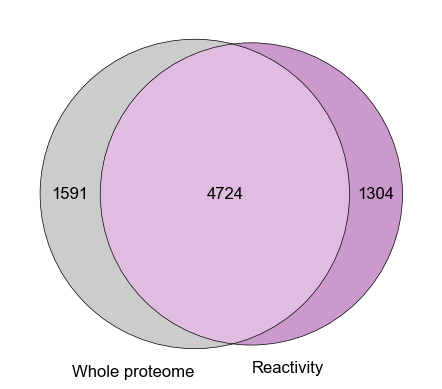

In [42]:
wp_rc_path = output_path / "wp_vs_reactivity"
wp_rc_path.mkdir(exist_ok=True)
# whole proteome vs reactivity data
wp_df = wp_file_path_all_channels_ratio_df

reactivity_path = "/Users/henrysanford/Dropbox @RU Dropbox/Vinogradova Laboratory/Exhaustion manuscript/02_Mass-spectrometry data/02_reactivity/03_rc_analysis/20240821_5_rep_variability_filter/04_combined_files/20240821_5_rep_variability_filter/07_combfiles_cysaggr_percctrl_passes_two_replicate_variability_filter.csv"
rc_df = pd.read_csv(reactivity_path)

wp_proteins = set(wp_df.reset_index()["uniprot"])
abpp_proteins = set(rc_df["uniprot"])
up_sets = [wp_proteins,abpp_proteins] 
out = venn2(subsets = up_sets, set_labels=["Whole proteome", "Reactivity"], set_colors=["grey", "purple"])
venn2_circles(subsets = up_sets, linewidth=0.5)
for text in out.subset_labels:
    text.set_fontsize(12)
    text.set_family("Arial")
for text in out.set_labels:
    text.set_fontsize(12)
    text.set_family("Arial")
plt.savefig(wp_rc_path / "wp_vs_reactivity.svg", bbox_inches = "tight")